In [1]:
import paddle
from paddle.io import Dataset,DataLoader
import paddle.nn.functional as F
from paddle import nn
import numpy as np
import os
from PIL import Image
import paddle.vision.transforms as T
import time
import json
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# **解压数据集**

In [2]:
!unzip -qo data/data89598/garbage.zip -d data

# **将json文件读出为字典，方便识别垃圾分类**

In [3]:
f = open("data/garbage/garbage_classify_rule.json","r")
file_dict = json.load(f)
print(file_dict)
f.close()

{'0': '其他垃圾/一次性快餐盒', '1': '其他垃圾/污损塑料', '2': '其他垃圾/烟蒂', '3': '其他垃圾/牙签', '4': '其他垃圾/破碎花盆及碟碗', '5': '其他垃圾/竹筷', '6': '厨余垃圾/剩饭剩菜', '7': '厨余垃圾/大骨头', '8': '厨余垃圾/水果果皮', '9': '厨余垃圾/水果果肉', '10': '厨余垃圾/茶叶渣', '11': '厨余垃圾/菜叶菜根', '12': '厨余垃圾/蛋壳', '13': '厨余垃圾/鱼骨', '14': '可回收物/充电宝', '15': '可回收物/包', '16': '可回收物/化妆品瓶', '17': '可回收物/塑料玩具', '18': '可回收物/塑料碗盆', '19': '可回收物/塑料衣架', '20': '可回收物/快递纸袋', '21': '可回收物/插头电线', '22': '可回收物/旧衣服', '23': '可回收物/易拉罐', '24': '可回收物/枕头', '25': '可回收物/毛绒玩具', '26': '可回收物/洗发水瓶', '27': '可回收物/玻璃杯', '28': '可回收物/皮鞋', '29': '可回收物/砧板', '30': '可回收物/纸板箱', '31': '可回收物/调料瓶', '32': '可回收物/酒瓶', '33': '可回收物/金属食品罐', '34': '可回收物/锅', '35': '可回收物/食用油桶', '36': '可回收物/饮料瓶', '37': '有害垃圾/干电池', '38': '有害垃圾/软膏', '39': '有害垃圾/过期药物'}


# **创建数据集**

In [4]:
class GarbageDataset(Dataset):
    def __init__(self,transforms=None,train="train"):
        super().__init__()
        self.transforms=transforms
        self.labels=list()
        self.datas=list()
        file_path=os.path.join("data/garbage",train) 
        #遍历train下的文件夹
        for file_name in os.listdir(file_path):  #file_name就是label,0、1、2、3、4、5
            sub_file_path=os.path.join(file_path,file_name) 
            #遍历子文件夹下的每一张图片
            for img_name in os.listdir(sub_file_path):
                if "DeepLearning - ┐ь╜▌╖╜╩╜.lnk" in img_name or "img_12074.jpg" in img_name:
                    continue
                img_path=os.path.join(sub_file_path,img_name)  
                #读取图片
                im=np.array(Image.open(img_path))
                if im is None:  #图不为空
                    continue
                if im.ndim==3:  #图片维度为3
                    self.datas.append(im)
                    self.labels.append(file_name)  #加入label

    def __getitem__(self,index):
        data=self.datas[index]
        if self.transforms!=None:
            data=self.transforms(data)
        label=int(self.labels[index])#np.array([int(self.labels[index])])
        x=paddle.to_tensor(label)
        y_data = paddle.cast(x, 'int64')
        y_data = paddle.reshape(y_data, (-1, 1))
        return data,label

    def __len__(self):
        return len(self.labels)

transforms=T.Compose([T.Resize([224,224]),T.ToTensor()])
train_dataset=GarbageDataset(transforms=transforms) # 训练集
test_dataset=GarbageDataset(transforms=transforms,train="test") # 测试集
valid_dataset = GarbageDataset(transforms=transforms,train="valid") # 验证集

# **加载数据集**

In [5]:
TrainDataLoader=DataLoader(dataset=train_dataset,shuffle=True,batch_size=100)
TestDataLoader=DataLoader(dataset=test_dataset,shuffle=True,batch_size=100)

# **resnet网络结构**

In [7]:
class IndentityBlock(paddle.nn.Layer):
    def __init__(self,in_channels,filters):
        super().__init__()
        F1,F2=filters
        self.stage=paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels=in_channels,out_channels=F1,kernel_size=3,stride=1,padding="same"),
            paddle.nn.BatchNorm2D(F1),
            paddle.nn.ReLU(),
            paddle.nn.Conv2D(in_channels=F1,out_channels=F2,kernel_size=3,stride=1,padding="same"),
            paddle.nn.BatchNorm2D(F2)
        )
        self.relu=paddle.nn.ReLU()

    def forward(self,x):
        shortcut_x=x
        x=self.stage(x)
        x=x+shortcut_x
        x=self.relu(x)
        return x

ib=IndentityBlock(64,(64,64))
paddle.summary(ib,(1,64,128,128))


class ConvBlock(paddle.nn.Layer):
    def __init__(self,in_channels,filters,stride=1):
        super().__init__()
        F1,F2=filters
        self.stage=paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels=in_channels,out_channels=F1,kernel_size=3,stride=stride,padding="same"),
            paddle.nn.BatchNorm2D(F1),
            paddle.nn.ReLU(),
            paddle.nn.Conv2D(in_channels=F1,out_channels=F2,kernel_size=3,stride=1,padding="same"),
            paddle.nn.BatchNorm2D(F2)
        )
        self.shortcut_x=paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels=in_channels,out_channels=F2,kernel_size=1,stride=stride,padding="same"),
            paddle.nn.BatchNorm2D(F2)
        )
        self.relu=paddle.nn.ReLU()

    def forward(self,x):
        shortcut_x=self.shortcut_x(x)
        x=self.stage(x)
        x=x+shortcut_x
        x=self.relu(x)
        return x

cb=ConvBlock(64,(64,64),2)
paddle.summary(cb,(1,64,128,128))


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-6     [[1, 64, 128, 128]]   [1, 64, 128, 128]       36,928     
 BatchNorm2D-6  [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
    ReLU-5      [[1, 64, 128, 128]]   [1, 64, 128, 128]          0       
   Conv2D-7     [[1, 64, 128, 128]]   [1, 64, 128, 128]       36,928     
 BatchNorm2D-7  [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
    ReLU-6      [[1, 64, 128, 128]]   [1, 64, 128, 128]          0       
Total params: 74,368
Trainable params: 73,856
Non-trainable params: 512
---------------------------------------------------------------------------
Input size (MB): 4.00
Forward/backward pass size (MB): 48.00
Params size (MB): 0.28
Estimated Total Size (MB): 52.28
---------------------------------------------------------------------------

----------------------------------------------------------------

{'total_params': 78784, 'trainable_params': 78016}

In [8]:
class ResNet34(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
    
        self.conv1 = paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding="same"),
            paddle.nn.ReLU(),
            paddle.nn.BatchNorm2D(64),
            paddle.nn.MaxPool2D(kernel_size=3,stride=2)
        )
        self.conv2 = paddle.nn.Sequential(
            IndentityBlock(64,(64,64)),
            IndentityBlock(64,(64,64)),
            IndentityBlock(64,(64,64))
        )
        self.conv3 = paddle.nn.Sequential(
            ConvBlock(64,(128,128),stride=2),
            IndentityBlock(128,(128,128)),
            IndentityBlock(128,(128,128)),
            IndentityBlock(128,(128,128))
        )
        self.conv4 = paddle.nn.Sequential(
            ConvBlock(128,(256,256),stride=2),
            IndentityBlock(256,(256,256)),
            IndentityBlock(256,(256,256)),
            IndentityBlock(256,(256,256)),
            IndentityBlock(256,(256,256)),
            IndentityBlock(256,(256,256))
        )
        self.conv5 = paddle.nn.Sequential(
            ConvBlock(256,(512,512),stride=2),
            IndentityBlock(512,(512,512)),
            IndentityBlock(512,(512,512))
        )
        self.fc = paddle.nn.Sequential(
            paddle.nn.AvgPool2D(512),
            paddle.nn.Flatten(),
            paddle.nn.Dropout(0.5),
            paddle.nn.Linear(in_features=512*1*1,out_features=40)
        )


    def forward(self,x):
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc(x)
        return x
    
resnet=ResNet34()
paddle.summary(resnet,(1,3,224,224))


-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-11      [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,472     
     ReLU-9       [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
 BatchNorm2D-11   [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
   MaxPool2D-1    [[1, 64, 112, 112]]    [1, 64, 55, 55]           0       
    Conv2D-12      [[1, 64, 55, 55]]     [1, 64, 55, 55]        36,928     
 BatchNorm2D-12    [[1, 64, 55, 55]]     [1, 64, 55, 55]          256      
     ReLU-10       [[1, 64, 55, 55]]     [1, 64, 55, 55]           0       
    Conv2D-13      [[1, 64, 55, 55]]     [1, 64, 55, 55]        36,928     
 BatchNorm2D-13    [[1, 64, 55, 55]]     [1, 64, 55, 55]          256      
     ReLU-11       [[1, 64, 55, 55]]     [1, 64, 55, 55]           0       
IndentityBlock-3   [[1, 64, 55, 55]]     [1, 64, 55, 55]           0       
    Conv2D

{'total_params': 21330728, 'trainable_params': 21296680}

# **训练模型并保持**

In [9]:
model=paddle.Model(resnet)
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()),loss=paddle.nn.CrossEntropyLoss(),metrics=paddle.metric.Accuracy())
vsDL=paddle.callbacks.VisualDL("dir_log"+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())) # 打印日志，方便过后查看损失率与准确率
model.fit(train_data=TrainDataLoader,epochs=40,callbacks=vsDL,verbose=1) # 训练集训练
model.evaluate(eval_data=TestDataLoader,verbose=1) # 测试集预测
model.save("mymodel/resnet") # 保存模型

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/40


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 119/119 [==============================] - loss: 4.0335 - acc: 0.0810 - 245ms/step          
Epoch 2/40
step 119/119 [==============================] - loss: 3.3628 - acc: 0.1379 - 242ms/step          
Epoch 3/40
step 119/119 [==============================] - loss: 3.7486 - acc: 0.1685 - 242ms/step          
Epoch 4/40
step 119/119 [==============================] - loss: 2.8190 - acc: 0.1855 - 241ms/step          
Epoch 5/40
step 119/119 [==============================] - loss: 2.5412 - acc: 0.2271 - 242ms/step          
Epoch 6/40
step 119/119 [==============================] - loss: 2.8184 - acc: 0.2535 - 244ms/step          
Epoch 7/40
step 119/119 [==============================] - loss: 2.9684 - acc: 0.2737 - 243ms/step          
Epoch 8/40
step 119/119 [==============================] - loss: 2.7726 - acc: 0.3152 - 242ms/step          
Epoch 9/40
step 119/119 [==============================] - loss: 2.0474 - acc: 0.3260 - 243ms/step          
Epoch 10/40
step 119/119 [====

In [10]:
# 加载模型
model=paddle.Model(resnet)
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()),
                loss=paddle.nn.CrossEntropyLoss(),metrics=paddle.metric.Accuracy())
model.load("mymodel/resnet")

In [11]:
#对验证集进行预测
result=model.predict(valid_dataset)

Predict begin...
step 1441/1441 [==============================] - 14ms/step          
Predict samples: 1441


混淆矩阵信息
[[ 4  0  0 ...  1  1  1]
 [ 0 12  1 ...  0  1  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  1  1 ... 18  2  0]
 [ 0  0  0 ...  1 18  1]
 [ 0  0  1 ...  0  6 17]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


计算各项指标
              precision    recall  f1-score   support

           0     0.8000    0.1667    0.2759        24
           1     0.3636    0.3243    0.3429        37
           2     0.4222    0.6786    0.5205        28
           3     0.4000    0.2222    0.2857         9
           4     0.2745    0.3590    0.3111        39
           5     0.7059    0.4138    0.5217        29
           6     0.5745    0.6750    0.6207        40
           7     0.5000    0.3056    0.3793        36
           8     0.8571    0.1579    0.2667        38
           9     0.5789    0.2821    0.3793        39
          10     0.9412    0.8205    0.8767        39
          11     0.5647    0.6486    0.6038        74
          12     0.4242    0.4242    0.4242        33
          13     0.0000    0.0000    0.0000         0
          14     0.3636    0.1111    0.1702        36
          15     0.3621    0.5000    0.4200        42
          16     0.4000    0.2857    0.3333        35
          17     0.2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


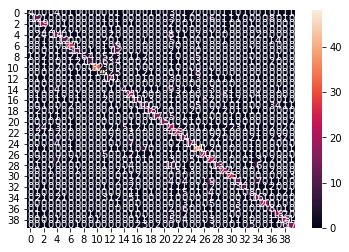

In [12]:
#使用混淆矩阵查看预测结果与真实值
#生成标签矩阵
labels = []
for i in range(40):
    labels.append(i)
def F1(x):
    return np.argmax(x[0])
yp=list(map(F1,result[0]))  #利用函数式编程，整理预测值
y_pred=yp
def F2(x):
    return x[1]
yt=list(map(F2,valid_dataset)) #利用函数式编程，整理真实值
y_true=yt
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import seaborn as sns
#混淆矩阵的制作
C = confusion_matrix(y_true=y_true,y_pred=y_pred,labels=labels)
#混淆矩阵信息
print("混淆矩阵信息")
print(C)
#把混淆矩阵C加入index和colums，封装成dataframe数据格式
df=pd.DataFrame(C,index=labels,columns=labels)
#展示热力图
sns.heatmap(C,annot=True)
print("计算各项指标")
#计算各项指标
print(classification_report(y_true=y_true,y_pred=y_pred,digits=4))


# **预测新图片**

可回收物/砧板


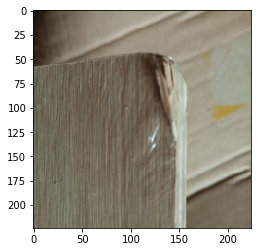

In [15]:
#载入图像方法
def image_load(img_path):
    photo=Image.open(img_path)
    photo=photo.resize([224,224])  #图像统一大小
    im=np.array(photo).astype("float32")    #图像数字化
    # im=np.where(im > 150, 0, im)        #把像素点大于150的置为0
    im=im/255                          #归一化
    im=paddle.to_tensor(im)            #张量
    return im
im=image_load("data/garbage/valid/29/img_14911.jpg")     #调用载入图像方法
plt.imshow(im)      #显示图像
im=im.reshape([1,3,224,224])   #图像变形为1张1通道28*28大小
model.load("mymodel2/resnet")   #加载模型参数
result=model.predict_batch(im)  #使用model.predict_batch对图像进行预测
print(file_dict[f"{np.argmax(result)}"])

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 